# **Python Final Project: Predicting Professional Tennis Games**

## Overall Question: Which player will win a tennis game?


## Step 1: Importing Libraries and Reading in the Dataset
---

In [ ]:
# Import Libraries that will be used throughout the code
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
from sklearn.exceptions import DataConversionWarning

from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import recall_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

import streamlit as st
import pickle

In [ ]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Read in all the Data(2000-2017), Original Link to Data: https://www.kaggle.com/datasets/gmadevs/atp-matches-dataset/data
games = pd.DataFrame()
for year in range(2000, 2018):
  current_games = pd.read_csv(f'/content/drive/My Drive/Spring 2025/Data Bootcamp/Final Project/Data/atp_matches_{year}.csv')
  games = pd.concat([games, current_games])

## Step 2: Exploring the initial dataset
---

### Very basic looking at data

In [ ]:
games.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,2000-717,Orlando,Clay,32,A,20000501.0,1.0,102179,NaN,NaN,...,15.0,13.0,4.0,110.0,59.0,49.0,31.0,17.0,4.0,4.0
1,2000-717,Orlando,Clay,32,A,20000501.0,2.0,103602,NaN,Q,...,6.0,0.0,0.0,57.0,24.0,13.0,17.0,10.0,4.0,9.0
2,2000-717,Orlando,Clay,32,A,20000501.0,3.0,103387,NaN,NaN,...,0.0,2.0,2.0,65.0,39.0,22.0,10.0,8.0,6.0,10.0
3,2000-717,Orlando,Clay,32,A,20000501.0,4.0,101733,NaN,NaN,...,12.0,4.0,6.0,104.0,57.0,35.0,24.0,15.0,6.0,11.0
4,2000-717,Orlando,Clay,32,A,20000501.0,5.0,101727,4.0,NaN,...,1.0,0.0,3.0,47.0,28.0,17.0,10.0,8.0,3.0,6.0


In [ ]:
games.info()
# Check types of variables and see what data is missing

<class 'pandas.core.frame.DataFrame'>
Index: 53571 entries, 0 to ('2017-M-DC-2017-WG-M-SUI-USA-01', 'Davis Cup WG R1: SUI vs USA', 'Hard', 4, 'D', 20170203, 5, 105449, nan, nan, 'Steve Johnson', 'R', 188.0, 'USA', 27.1019849418, 31.0, 1345.0, 134472, nan, nan)
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          53508 non-null  object 
 1   tourney_name        53494 non-null  object 
 2   surface             52250 non-null  object 
 3   draw_size           53508 non-null  object 
 4   tourney_level       53500 non-null  object 
 5   tourney_date        53440 non-null  float64
 6   match_num           53440 non-null  float64
 7   winner_id           53508 non-null  object 
 8   winner_seed         24126 non-null  float64
 9   winner_entry        9221 non-null   object 
 10  winner_name         53472 non-null  object 
 11  winner_hand         53458 non-null  object 
 12  winner_ht      

### Cleaning the Dataset

In [ ]:
# Cutting down the dataset to only the portion where the statistics are available. We drop the portion where the winner's ace statistic is missing
games = games.dropna(subset=['w_ace'])

In [ ]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44451 entries, 0 to 2629
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          44451 non-null  object 
 1   tourney_name        44451 non-null  object 
 2   surface             44451 non-null  object 
 3   draw_size           44451 non-null  object 
 4   tourney_level       44451 non-null  object 
 5   tourney_date        44451 non-null  float64
 6   match_num           44451 non-null  float64
 7   winner_id           44451 non-null  object 
 8   winner_seed         20505 non-null  float64
 9   winner_entry        5837 non-null   object 
 10  winner_name         44451 non-null  object 
 11  winner_hand         44451 non-null  object 
 12  winner_ht           43611 non-null  float64
 13  winner_ioc          44451 non-null  object 
 14  winner_age          44451 non-null  float64
 15  winner_rank         43849 non-null  float64
 16  winner_ran

In [ ]:
# Fill all entries that are not Q or WC with DA (Direct Acceptance based on rank)
games.loc[:, 'winner_entry'] = games['winner_entry'].astype('object').fillna('DA')
games['loser_entry'] = games['loser_entry'].astype('object').fillna('DA')

# Any players without a seed are assumed to have been not seeded
games['winner_seed'] = games['winner_seed'].astype('object').fillna('Not Seeded')
games['loser_seed'] = games['loser_seed'].astype('object').fillna('Not Seeded')

# Impute minutes with the mean
games['minutes'] = games['minutes'].fillna(games['minutes'].mean())

# Assumes players without rank points just had 0 rank points when playing
games['winner_rank_points'] = games['winner_rank_points'].fillna(0)
games['loser_rank_points'] = games['loser_rank_points'].fillna(0)

# Replace players with missing ranks with Not Ranked (If they have 0 rank points, makes sense)
games['winner_rank'] = games['winner_rank'].astype('object').fillna('Not Ranked')
games['loser_rank'] = games['loser_rank'].astype('object').fillna('Not Ranked')

# Impute missing height with the mean
games['winner_ht'] = games['winner_ht'].fillna(games['winner_ht'].mean())
games['loser_ht'] = games['loser_ht'].fillna(games['loser_ht'].mean())

# One missing age value, replaced with mean age
games['loser_age'] = games['loser_age'].fillna(games['loser_age'].mean())

In [ ]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44451 entries, 0 to 2629
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          44451 non-null  object 
 1   tourney_name        44451 non-null  object 
 2   surface             44451 non-null  object 
 3   draw_size           44451 non-null  object 
 4   tourney_level       44451 non-null  object 
 5   tourney_date        44451 non-null  float64
 6   match_num           44451 non-null  float64
 7   winner_id           44451 non-null  object 
 8   winner_seed         44451 non-null  object 
 9   winner_entry        44451 non-null  object 
 10  winner_name         44451 non-null  object 
 11  winner_hand         44451 non-null  object 
 12  winner_ht           44451 non-null  float64
 13  winner_ioc          44451 non-null  object 
 14  winner_age          44451 non-null  float64
 15  winner_rank         44451 non-null  object 
 16  winner_ran

In [ ]:
# Identify the winner and loser columns
winner_cols = ['winner_id', 'winner_seed', 'winner_entry', 'winner_name', 'winner_hand',
               'winner_ht', 'winner_ioc', 'winner_age', 'winner_rank', 'winner_rank_points']

loser_cols = ['loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
              'loser_ht', 'loser_ioc', 'loser_age', 'loser_rank', 'loser_rank_points']

# Identify the player stats columns
winner_stats = [col for col in games.columns if col.startswith('w_')]
loser_stats = [col for col in games.columns if col.startswith('l_')]

# Extract the columns that have to do with the players
player_1 = games[winner_cols + winner_stats].copy()
player_2 = games[loser_cols + loser_stats].copy()

# For these columns, then rename with player 1 and player 2 to remove the winner/loser label
player_1.columns = ['player_1_' + col.replace('winner_', '').replace('w_', '') for col in player_1.columns]
player_2.columns = ['player_2_' + col.replace('loser_', '').replace('l_', '') for col in player_2.columns]

# Identify the shared columns (non-player columns) in the dataset
shared_cols = ['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
               'tourney_date', 'match_num', 'score', 'best_of', 'round', 'minutes']
shared = games[shared_cols].copy()

# Combine all the parts after renaming into the new database
games = pd.concat([shared, player_1, player_2], axis=1)

# Randomly swap 50% of player_1 and player_2
swap_mask = np.random.rand(len(games)) < 0.5

p1_cols = [col for col in games.columns if col.startswith('player_1_')]
p2_cols = [col for col in games.columns if col.startswith('player_2_')]

# Perform swap on those rows
games.loc[swap_mask, p1_cols + p2_cols] = games.loc[swap_mask, p2_cols + p1_cols].values

# Create target variable, with 1 if the 1st player is the one that won, and 0
games['target'] = 1
games.loc[swap_mask, 'target'] = 0

In [ ]:
# Map the tourney_level to more understandable terms, currently just one letter each
tourney_level_mapping = {'A': 'ATP/ITF', 'C': 'Challenger', 'F': 'Futures', 'G': 'Grand Slam', 'M': 'Masters 1000'}

# Apply the mapping to the tourney_level column
games['tourney_level'] = games['tourney_level'].map(tourney_level_mapping)

In [ ]:
# To check if the data has really been swapped properly, comparing to the original
# games.to_csv('processed_games.csv', index=False)

### Actually looking at the data after cleaning

In [ ]:
games.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,player_2_ace,player_2_df,player_2_svpt,player_2_1stIn,player_2_1stWon,player_2_2ndWon,player_2_SvGms,player_2_bpSaved,player_2_bpFaced,target
0,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,1.0,3-6 7-6(6) 7-6(4),3.0,R32,...,13.0,4.0,110.0,59.0,49.0,31.0,17.0,4.0,4.0,1
1,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,2.0,6-2 7-5,3.0,R32,...,4.0,2.0,67.0,35.0,25.0,16.0,10.0,4.0,6.0,0
2,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,3.0,6-1 6-3,3.0,R32,...,4.0,1.0,46.0,29.0,23.0,11.0,8.0,0.0,0.0,0
3,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,4.0,4-6 6-2 7-5,3.0,R32,...,8.0,6.0,109.0,56.0,43.0,21.0,15.0,9.0,12.0,0
4,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,5.0,6-1 6-4,3.0,R32,...,0.0,3.0,47.0,28.0,17.0,10.0,8.0,3.0,6.0,1


In [ ]:
games.info()
# Check types of variables and make sure these is nothing missing

<class 'pandas.core.frame.DataFrame'>
Index: 44451 entries, 0 to 2629
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tourney_id            44451 non-null  object 
 1   tourney_name          44451 non-null  object 
 2   surface               44451 non-null  object 
 3   draw_size             44451 non-null  object 
 4   tourney_level         44451 non-null  object 
 5   tourney_date          44451 non-null  float64
 6   match_num             44451 non-null  float64
 7   score                 44451 non-null  object 
 8   best_of               44451 non-null  float64
 9   round                 44451 non-null  object 
 10  minutes               44451 non-null  float64
 11  player_1_id           44451 non-null  object 
 12  player_1_seed         44451 non-null  object 
 13  player_1_entry        44451 non-null  object 
 14  player_1_name         44451 non-null  object 
 15  player_1_hand         444

In [ ]:
# Understand the Numerical Variables in General
games.describe()

,tourney_date,match_num,best_of,minutes,player_1_ht,player_1_age,player_1_rank_points,player_1_ace,player_1_df,player_1_svpt,...,player_2_ace,player_2_df,player_2_svpt,player_2_1stIn,player_2_1stWon,player_2_2ndWon,player_2_SvGms,player_2_bpSaved,player_2_bpFaced,target
count,4.445100e+04,44451.000000,44451.000000,44451.000000,44451.000000,44451.000000,44451.000000,44451.000000,44451.000000,44451.000000,...,44451.000000,44451.000000,44451.000000,44451.000000,44451.000000,44451.000000,44451.000000,44451.000000,44451.000000,44451.000000
mean,2.007363e+07,29.215316,3.368901,103.905698,185.372929,26.108577,1232.840589,5.870082,2.991721,78.647927,...,5.867225,2.994848,78.630447,47.353940,33.618411,15.810038,12.263391,4.105104,6.833502,0.499561
std,4.596192e+04,27.019070,0.775711,39.093176,6.613468,3.580305,1582.251775,5.145017,2.425896,29.022584,...,5.197668,2.427439,29.005384,18.889856,13.948170,7.179213,4.187372,3.233872,4.455643,0.500005
min,2.000010e+07,1.000000,3.000000,3.000000,163.000000,15.545517,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.003091e+07,11.000000,3.000000,75.000000,180.000000,23.498973,489.000000,2.000000,1.000000,58.000000,...,2.000000,1.000000,58.000000,34.000000,24.000000,11.000000,9.000000,2.000000,4.000000,0.000000
50%,2.007073e+07,21.000000,3.000000,98.000000,185.000000,26.020534,779.000000,5.000000,2.000000,74.000000,...,5.000000,3.000000,74.000000,44.000000,31.000000,15.000000,11.000000,4.000000,6.000000,0.000000
75%,2.011082e+07,36.000000,3.000000,124.000000,190.000000,28.594114,1300.000000,8.000000,4.000000,95.000000,...,8.000000,4.000000,95.000000,57.000000,41.000000,20.000000,15.000000,6.000000,9.000000,1.000000
max,2.015112e+07,127.000000,5.000000,665.000000,208.000000,43.830253,15785.000000,103.000000,23.000000,489.000000,...,113.000000,23.000000,491.000000,361.000000,292.000000,82.000000,90.000000,25.000000,34.000000,1.000000


In [ ]:
# Understand the Categorical Variables
games.describe(include = ['category', 'object'])

,tourney_id,tourney_name,surface,draw_size,tourney_level,score,round,player_1_id,player_1_seed,player_1_entry,player_1_name,player_1_hand,player_1_ioc,player_1_rank,player_2_seed,player_2_entry,player_2_name,player_2_hand,player_2_ioc,player_2_rank
count,44451,44451,44451,44451,44451,44451,44451,44451.0,44451,44451,44451,44451,44451,44451,44451,44451,44451,44451,44451,44451
unique,1072,115,4,9,5,7876,8,1031.0,36,5,1031,3,81,763,36,6,1016,3,79,773
top,2010-520,Wimbledon,Hard,32,ATP/ITF,6-3 6-4,R32,103819.0,Not Seeded,DA,Roger Federer,R,ESP,Not Ranked,Not Seeded,DA,Roger Federer,R,ESP,Not Ranked
freq,127,2027,23462,17027,27058,1544,15801,609.0,28700,36694,609,38715,5850,641,28742,36593,596,38772,5970,642


In [ ]:
games.shape

(44451, 50)

In [ ]:
games['tourney_name'].value_counts()

,count
tourney_name,
Wimbledon,2027
US Open,2026
Roland Garros,2026
Australian Open,2024
Miami Masters,1504
...,...
Viña del Mar,27
Quito,27
Istanbul,27


In [ ]:
games['player_1_ioc'].value_counts()

,count
player_1_ioc,
ESP,5850
FRA,4490
USA,3962
ARG,3146
GER,2823
...,...
ESA,2
HKG,1
VIE,1


In [ ]:
games['player_1_name'].value_counts()

,count
player_1_name,
Roger Federer,609
David Ferrer,469
Rafael Nadal,450
Tommy Robredo,430
Mikhail Youzhny,406
...,...
Alexander Sarkissian,1
James Mcgee,1
Tommy Paul,1


In [ ]:
games['player_1_entry'].value_counts()

,count
player_1_entry,
DA,36694
Q,4550
WC,2649
LL,550
PR,8


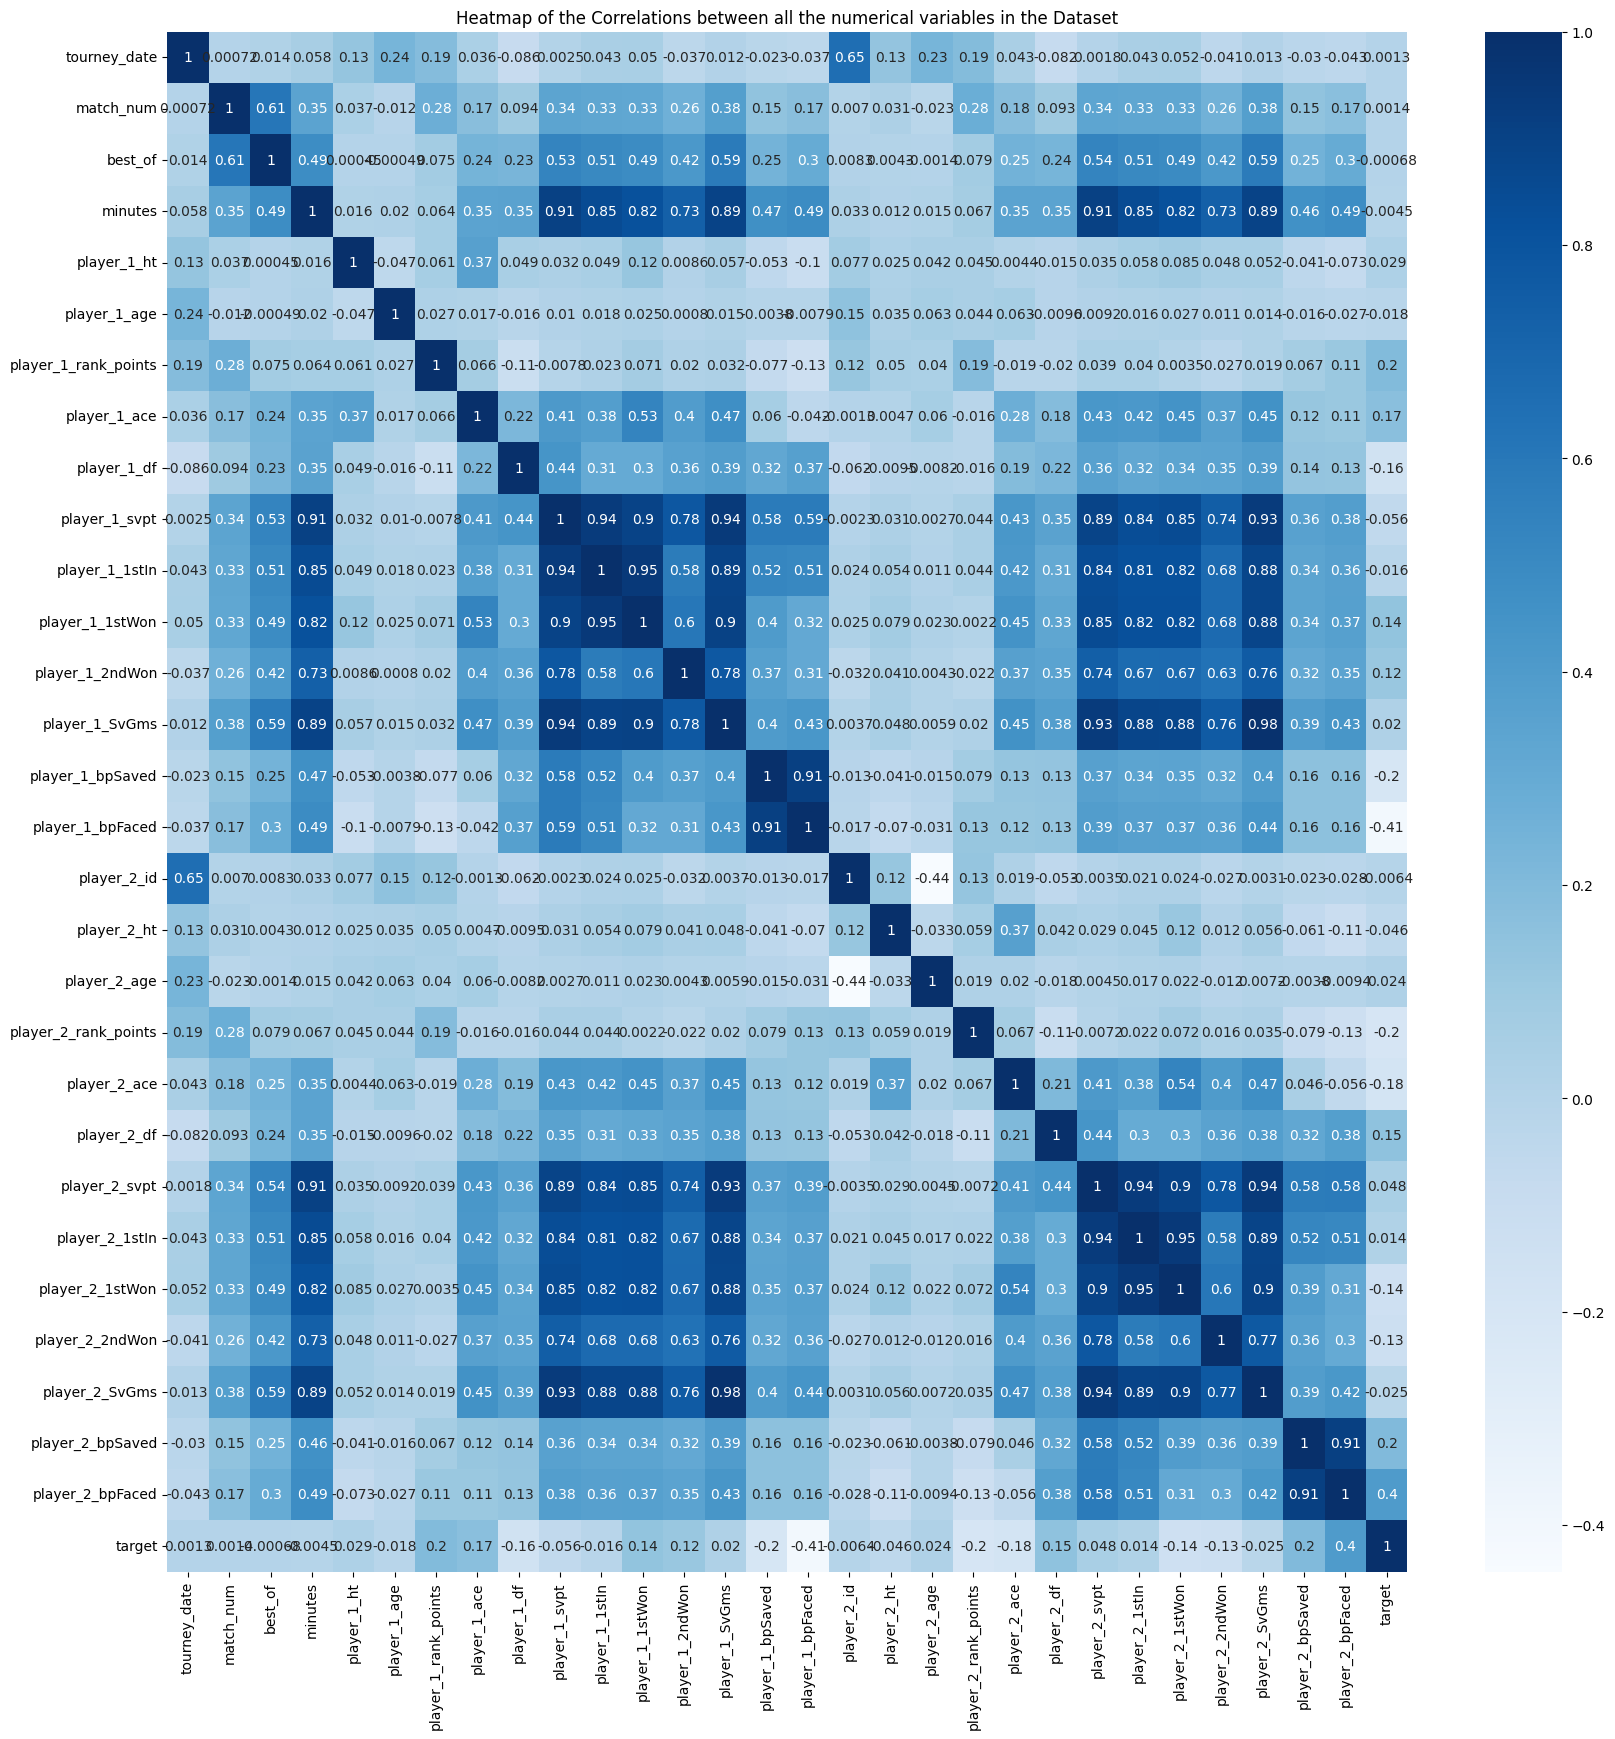

In [ ]:
numerical_columns = games.select_dtypes(include='number')
plt.figure(figsize = (20, 20))
sns.heatmap(numerical_columns.corr(), cmap="Blues", annot=True)
plt.title("Heatmap of the Correlations between all the numerical variables in the Dataset");

## Step 3: Visualizing columns to understand distributions
---

In [ ]:
def plot_stat(games, stat_name, actual_name):
  """
  Creates three side-by-side plots comparing a specific player statistic:
  1. Histogram
  2. KDE/Density plot
  3. Scatter plot

  Parameters
  games - pandas DataFrame containing the player statistics
  stat_name - name of the statistic to plot (without 'player_1_' or 'player_2_' prefix)
  actual_name - name of the statistic actually, for easier readability

  Returns
  A figure containing the 3 plots
  """
  p1_col = f'player_1_{stat_name}'
  p2_col = f'player_2_{stat_name}'

  # Create figure with three subplots
  fig, axes = plt.subplots(1, 3, figsize = (18, 5))

  # Get stat range for consistent bin sizes
  min_val = min(games[p1_col].min(), games[p2_col].min())
  max_val = max(games[p1_col].max(), games[p2_col].max()) * 1.01

  # Create bins
  bins = np.linspace(min_val, max_val, 30)

  # Create the Histogram
  box_data = pd.DataFrame({
      stat_name: pd.concat([games[p1_col], games[p2_col]]),
      'Player': ['Player 1'] * len(games) + ['Player 2'] * len(games)})
  sns.boxplot(x = 'Player', y = stat_name, data=box_data, ax=axes[0])
  axes[0].set_title(f'Boxplot of {actual_name}')
  axes[0].grid(alpha=0.3)

  # Create the KDE plot
  sns.kdeplot(data=games, x=p1_col, label='Player 1', ax=axes[1])
  sns.kdeplot(data=games, x=p2_col, label='Player 2', ax=axes[1])
  axes[1].set_title(f'Density Distribution of {actual_name}')
  axes[1].set_xlabel(f'{actual_name} Value')
  axes[1].grid(alpha=0.3)
  axes[1].legend()

  # Create the Scatter plot
  axes[2].scatter(games[p1_col], games[p2_col], alpha=0.3, s=15)
  max_val = max(games[p1_col].max(), games[p2_col].max())
  axes[2].plot([0, max_val], [0, max_val], 'r--', alpha=0.7, label='Equal Values Line')
  axes[2].set_title(f'Player 1 vs Player 2 {actual_name}')
  axes[2].set_xlabel(f'Player 1 {actual_name}')
  axes[2].set_ylabel(f'Player 2 {actual_name}')
  axes[2].grid(alpha=0.3)
  axes[2].legend()

  plt.tight_layout()
  fig.suptitle(f'Comparison of {actual_name} Between Players', y=1.05, fontsize=16)

  plt.close(fig)
  return fig

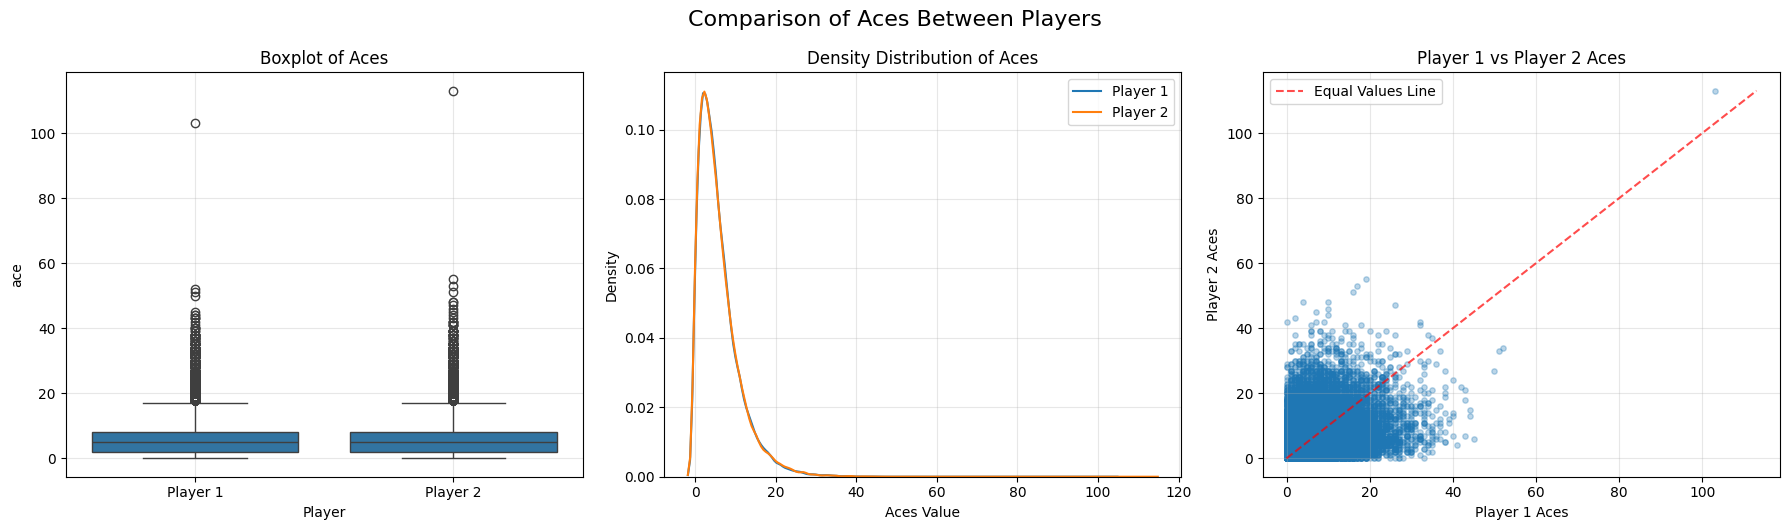

In [ ]:
plot_stat(games, 'ace', 'Aces')

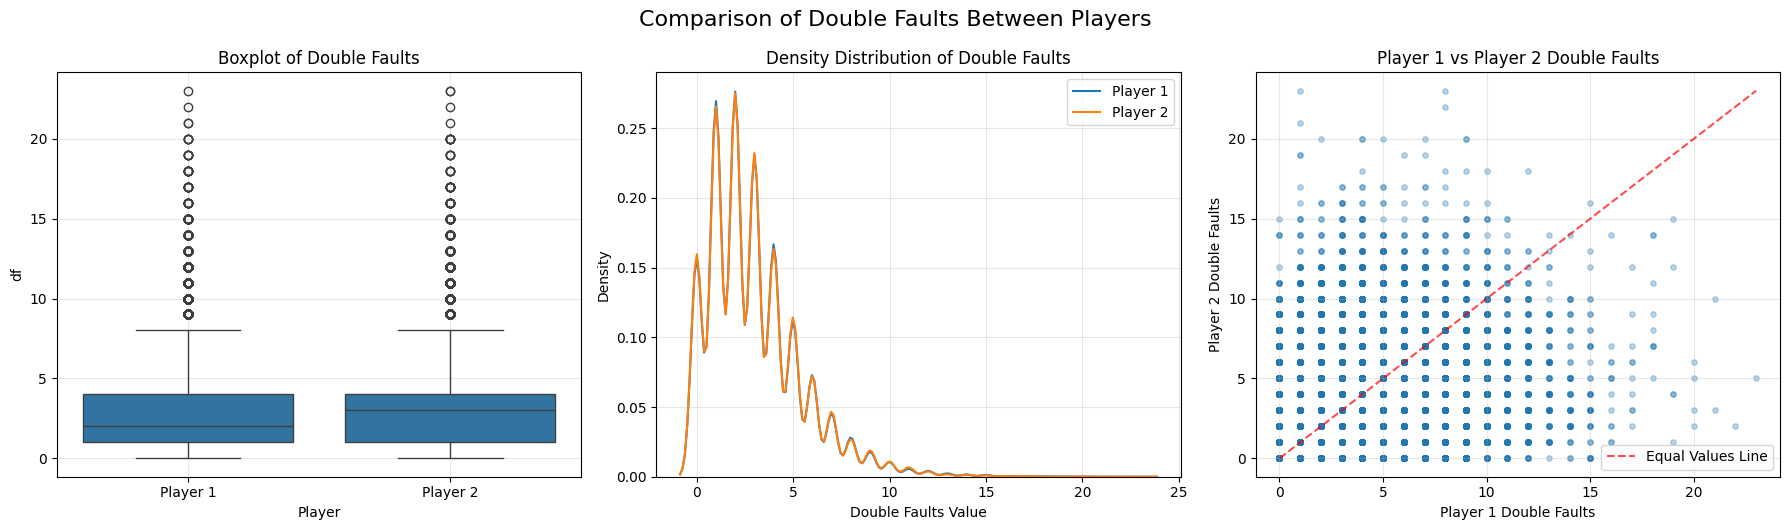

In [ ]:
plot_stat(games, 'df', 'Double Faults')

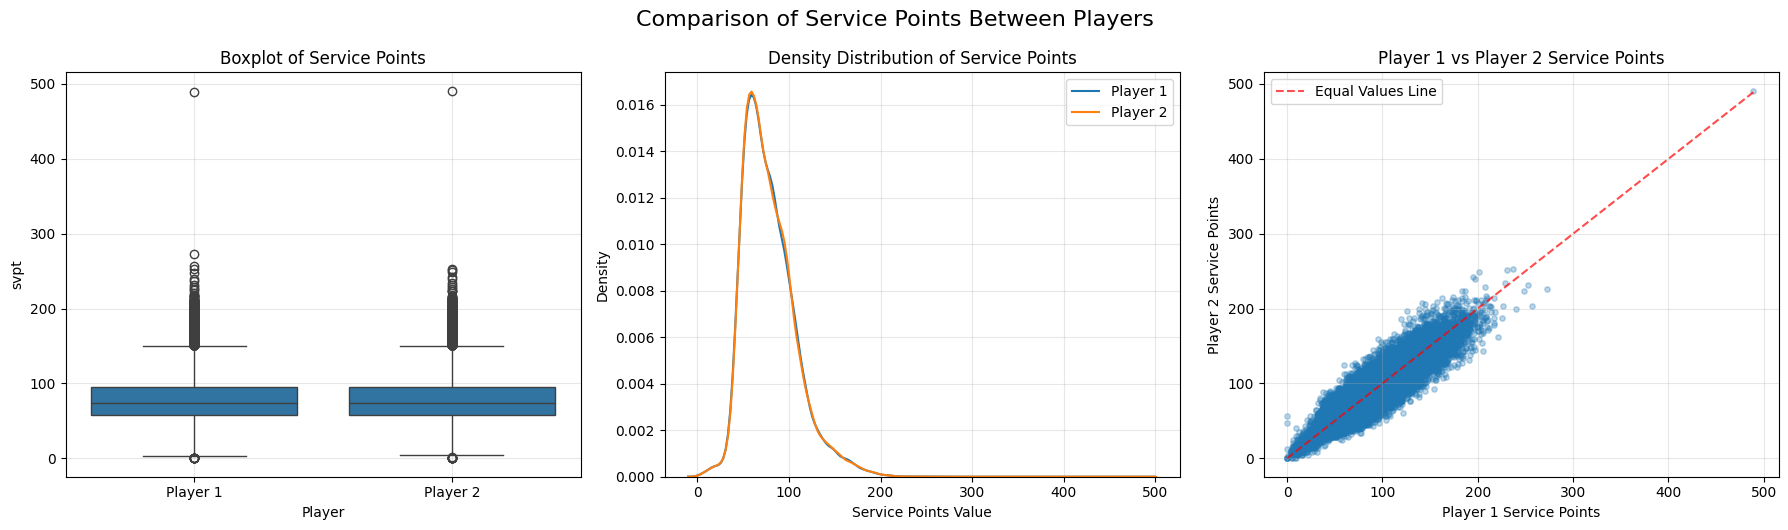

In [ ]:
plot_stat(games, 'svpt', 'Service Points')

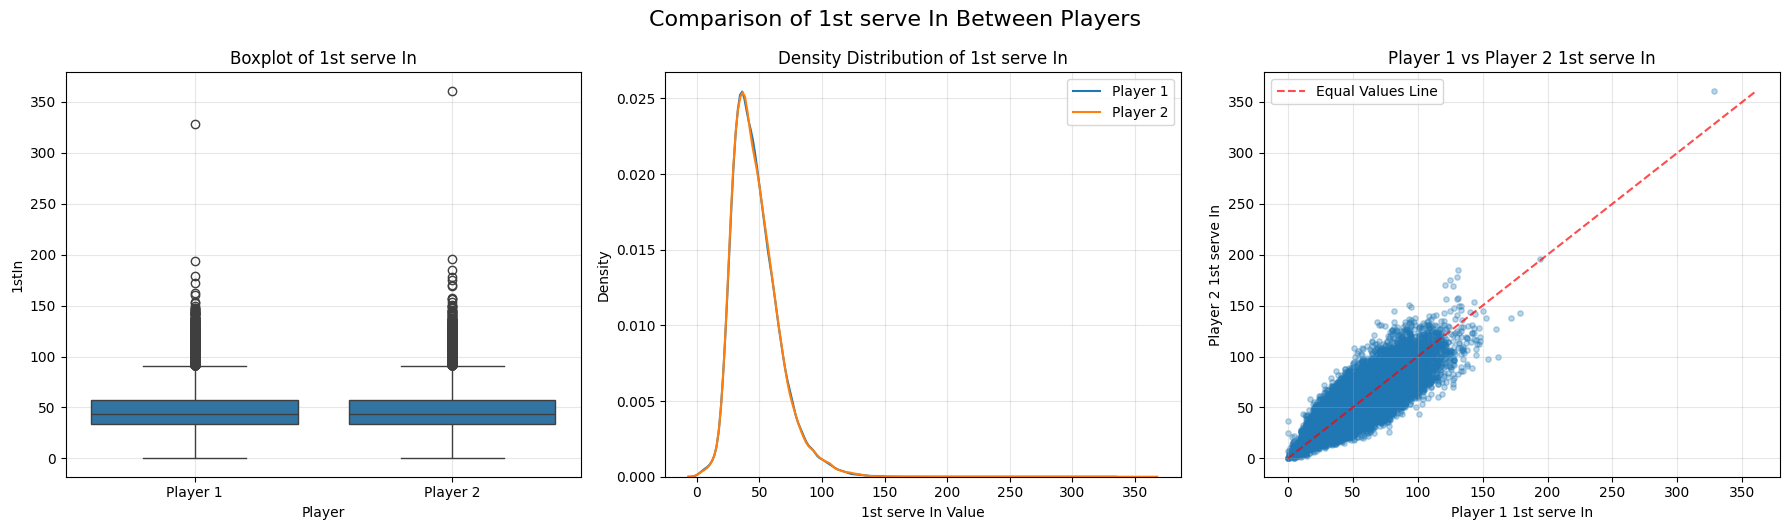

In [ ]:
plot_stat(games, '1stIn', '1st serve In')

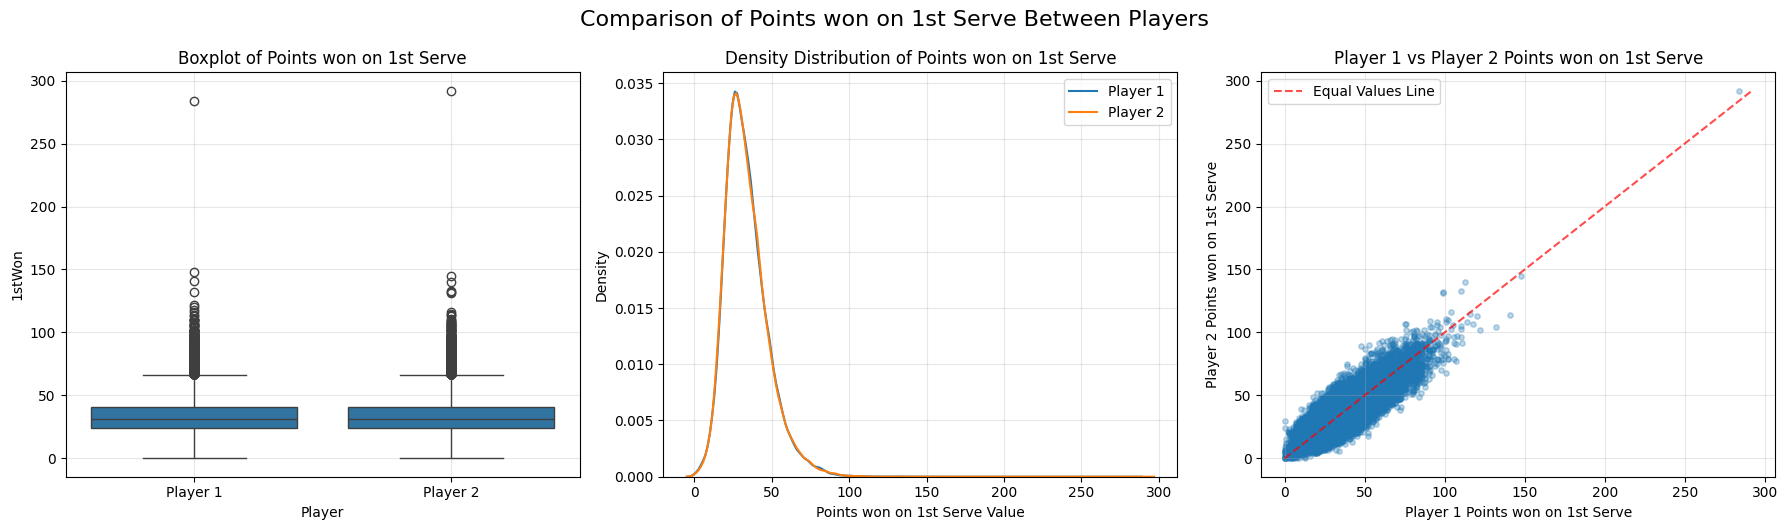

In [ ]:
plot_stat(games, '1stWon', 'Points won on 1st Serve')

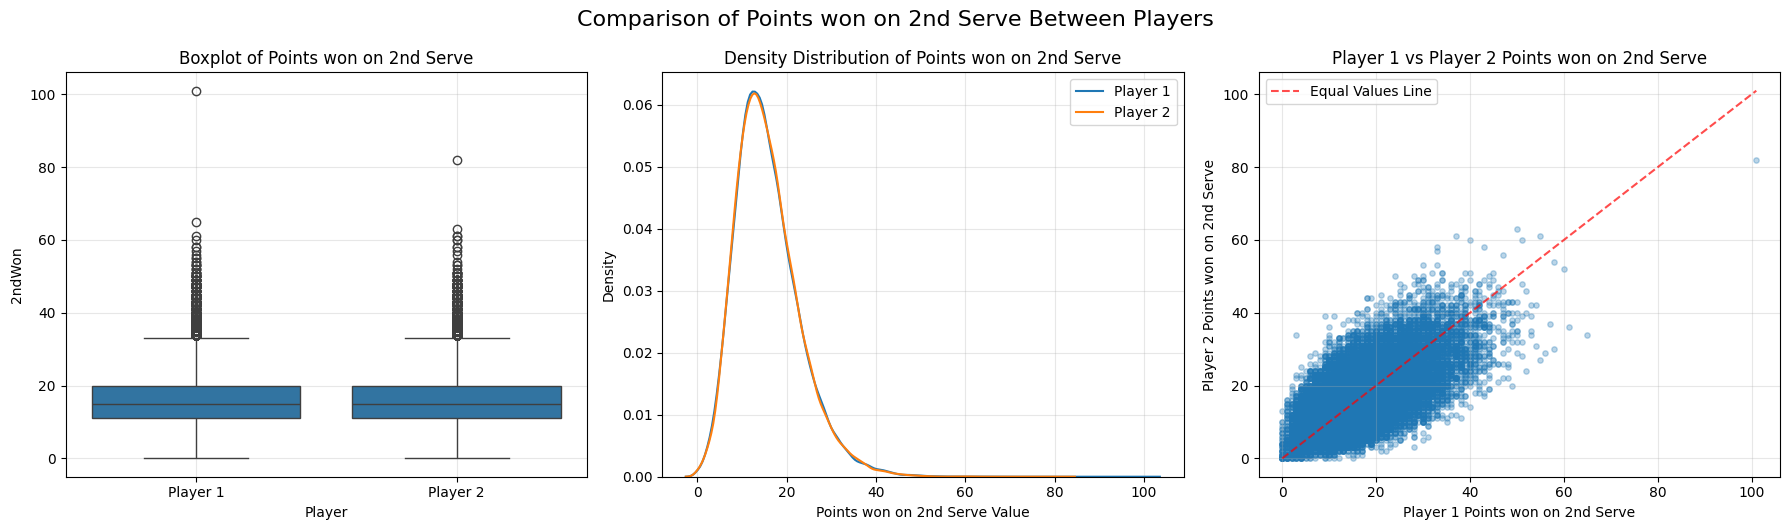

In [ ]:
plot_stat(games, '2ndWon', 'Points won on 2nd Serve')

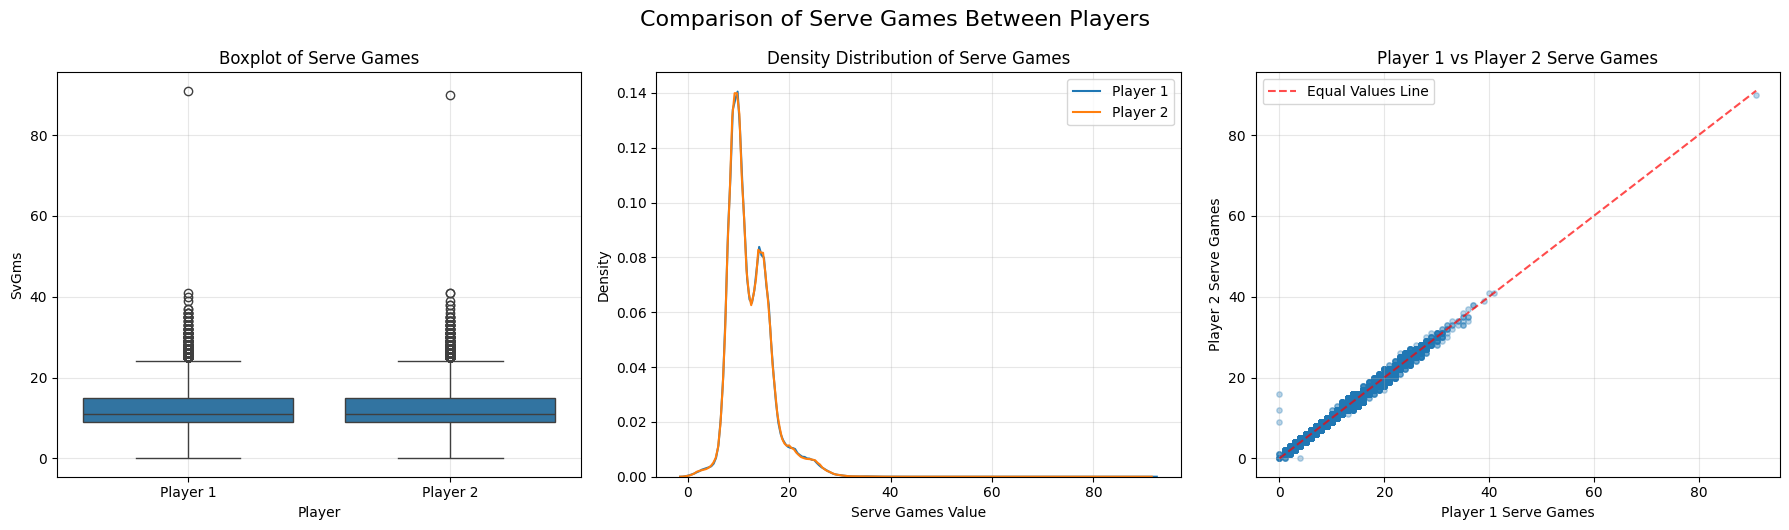

In [ ]:
plot_stat(games, 'SvGms', 'Serve Games')

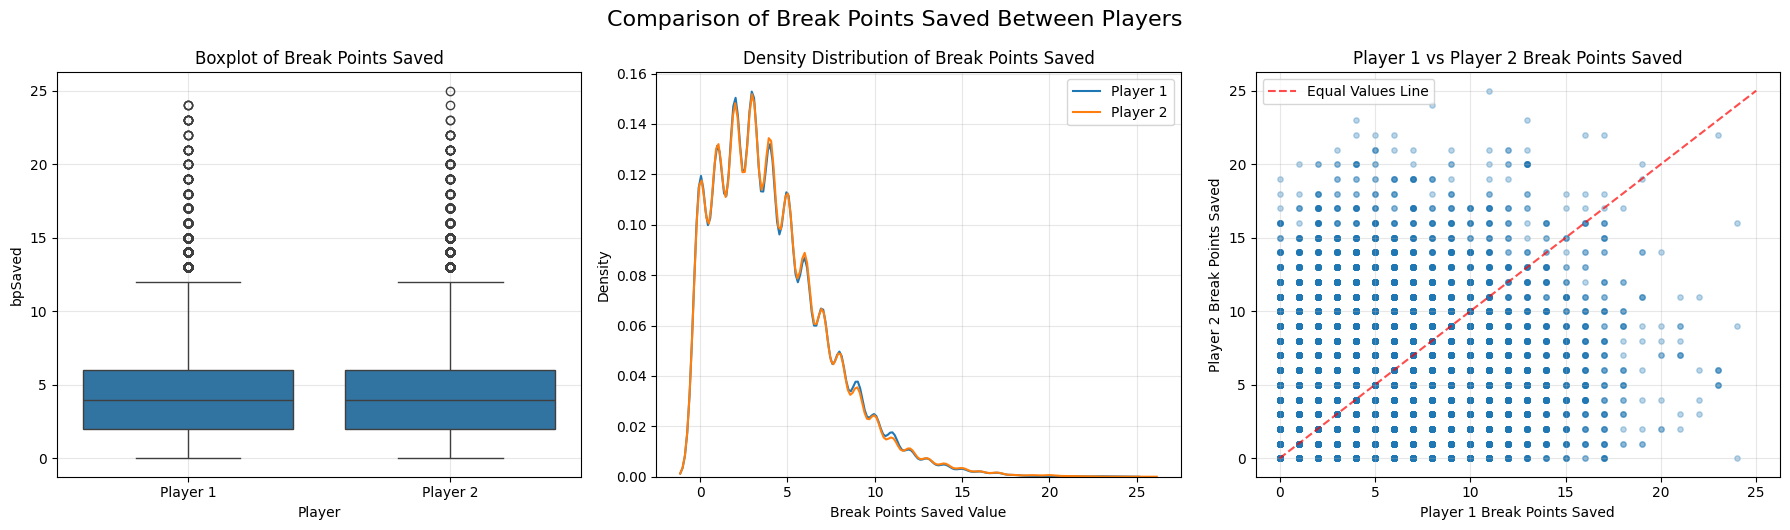

In [ ]:
plot_stat(games, 'bpSaved', 'Break Points Saved')

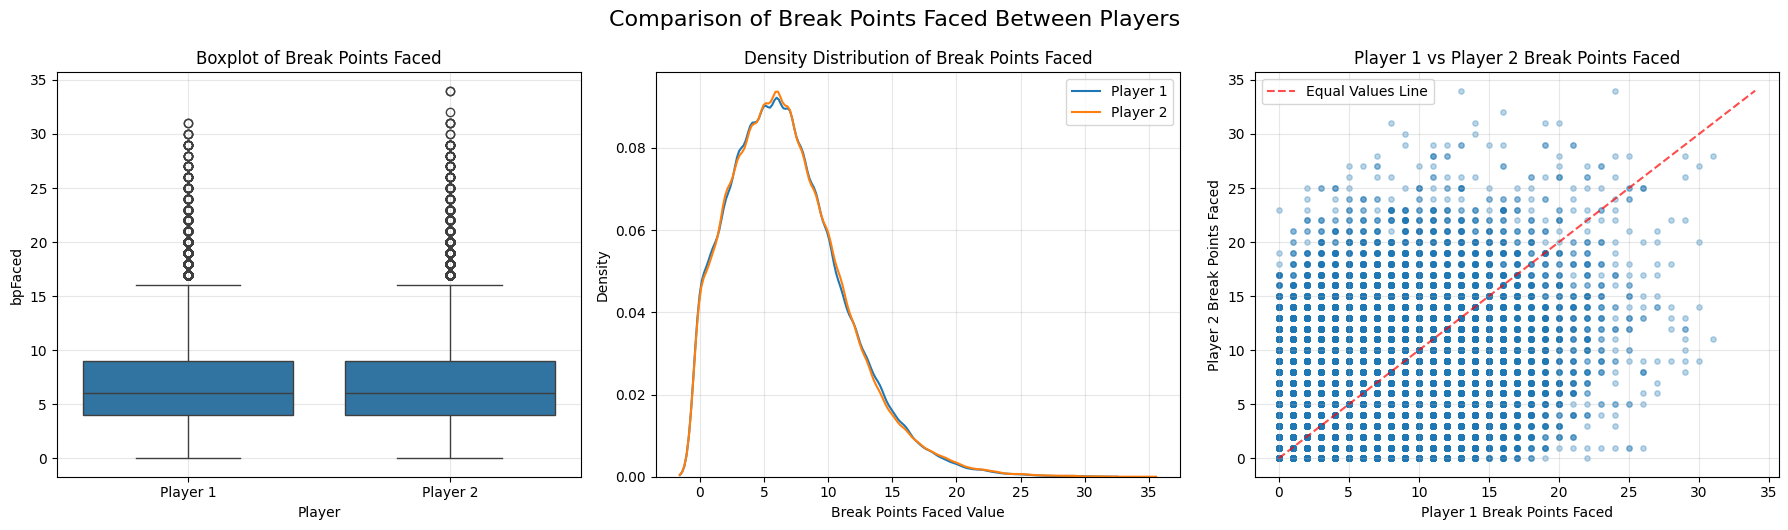

In [ ]:
plot_stat(games, 'bpFaced', 'Break Points Faced')

## Step 4: EDA

### Some Guiding Questions:

Seeding Questions:
* Does seeding for a tournament affect how much chance a player has of winning * What about the difference in seeding?

Rank Questions:
* Does the number of ranking points a player has impact their ability to win?
* Does the tournament(Grand Slam/Masters/Location) affect how important the rank is?
* Does having more ranking points improve one’s chances as time goes on (with longer games)?

Height Question:
* How much does height matter for a player’s chance of winning?

Ace Questions:
* How important is getting aces in a game?
* Does the type of court affect how important aces are to win?

Serve Questions:
* Does having a high first serve in number correspond to a higher percent win?
* What about the comparison between 1st serve points won and 2nd serve points won?

Break Point Questions:
* Does the number of breakpoints faced correspond to chance of winning?
* Does the round in a tournament matter for how important breakpoints are?

Player Questions
* Does how many games in a row a player has won contribute to their ability to win the next game?
* Do certain Players play better on certain surfaces?


### Seeding(1): Does seeding for a tournament affect how much chance a player has of winning?

Text(0.5, 1.0, 'Player 1 Win Rate by Seed')

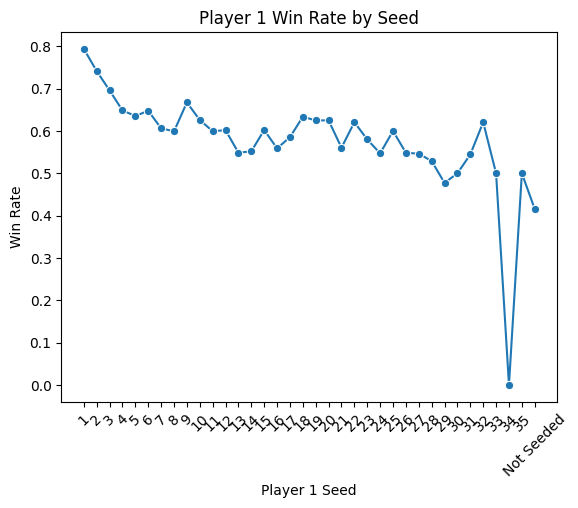

In [ ]:
# Calculate win rate
seed_winrate = games.groupby('player_1_seed')['target'].mean().reset_index()

# Separate numeric and non-numeric seeds
numeric_seeds = seed_winrate[seed_winrate['player_1_seed'] != 'Not Seeded'].copy()
numeric_seeds['player_1_seed'] = numeric_seeds['player_1_seed'].astype(int)
numeric_seeds = numeric_seeds.sort_values('player_1_seed')

# Convert back to string for uniformity
numeric_seeds['player_1_seed'] = numeric_seeds['player_1_seed'].astype(str)

# Handle 'Not Seeded'
not_seeded = seed_winrate[seed_winrate['player_1_seed'] == 'Not Seeded']

# Combine and keep player_1_seed as string/categorical
sorted_seed_winrate = pd.concat([numeric_seeds, not_seeded])

# Plot
sns.lineplot(data=sorted_seed_winrate, x='player_1_seed', y='target', marker="o")
plt.xticks(rotation=45)
plt.ylabel("Win Rate")
plt.xlabel("Player 1 Seed")
plt.title("Player 1 Win Rate by Seed")


### Seeding(2): Does difference in seeding for a tournament affect how much chance a player has of winning?

In [ ]:
# Function to convert seeds and compute difference
def seeding_diff(seed1, seed2):
  s1 = 36 if seed1 == 'Not Seeded' else int(seed1)
  s2 = 36 if seed2 == 'Not Seeded' else int(seed2)
  return s1 - s2

# Using lambda to apply the function to every row in the dataset
games['seeding_difference'] = games.apply(lambda row: seeding_diff(row['player_1_seed'], row['player_2_seed']), axis = 1)
games

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,round,...,player_2_df,player_2_svpt,player_2_1stIn,player_2_1stWon,player_2_2ndWon,player_2_SvGms,player_2_bpSaved,player_2_bpFaced,target,seeding_difference
0,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,1.0,3-6 7-6(6) 7-6(4),3.0,R32,...,4.0,110.0,59.0,49.0,31.0,17.0,4.0,4.0,1,35
1,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,2.0,6-2 7-5,3.0,R32,...,2.0,67.0,35.0,25.0,16.0,10.0,4.0,6.0,0,0
2,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,3.0,6-1 6-3,3.0,R32,...,1.0,46.0,29.0,23.0,11.0,8.0,0.0,0.0,0,0
3,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,4.0,4-6 6-2 7-5,3.0,R32,...,6.0,109.0,56.0,43.0,21.0,15.0,9.0,12.0,0,-28
4,2000-717,Orlando,Clay,32,ATP/ITF,20000501.0,5.0,6-1 6-4,3.0,R32,...,3.0,47.0,28.0,17.0,10.0,8.0,3.0,6.0,1,-32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,2015-605,Tour Finals,Hard,8,Futures,20151115.0,11.0,6-7(2) 6-3 6-4,3.0,RR,...,2.0,93.0,59.0,38.0,23.0,16.0,4.0,7.0,0,2
2626,2015-605,Tour Finals,Hard,8,Futures,20151115.0,12.0,7-6(4) 6-4,3.0,RR,...,4.0,80.0,36.0,27.0,26.0,11.0,8.0,10.0,0,-2
2627,2015-605,Tour Finals,Hard,8,Futures,20151115.0,14.0,6-3 6-3,3.0,SF,...,0.0,53.0,37.0,20.0,11.0,9.0,2.0,5.0,1,-4
2628,2015-605,Tour Finals,Hard,8,Futures,20151115.0,13.0,7-5 6-3,3.0,SF,...,2.0,63.0,39.0,27.0,10.0,10.0,3.0,6.0,1,-1


Text(0.5, 1.0, 'Player 1 Win Rate by Seeding Difference')

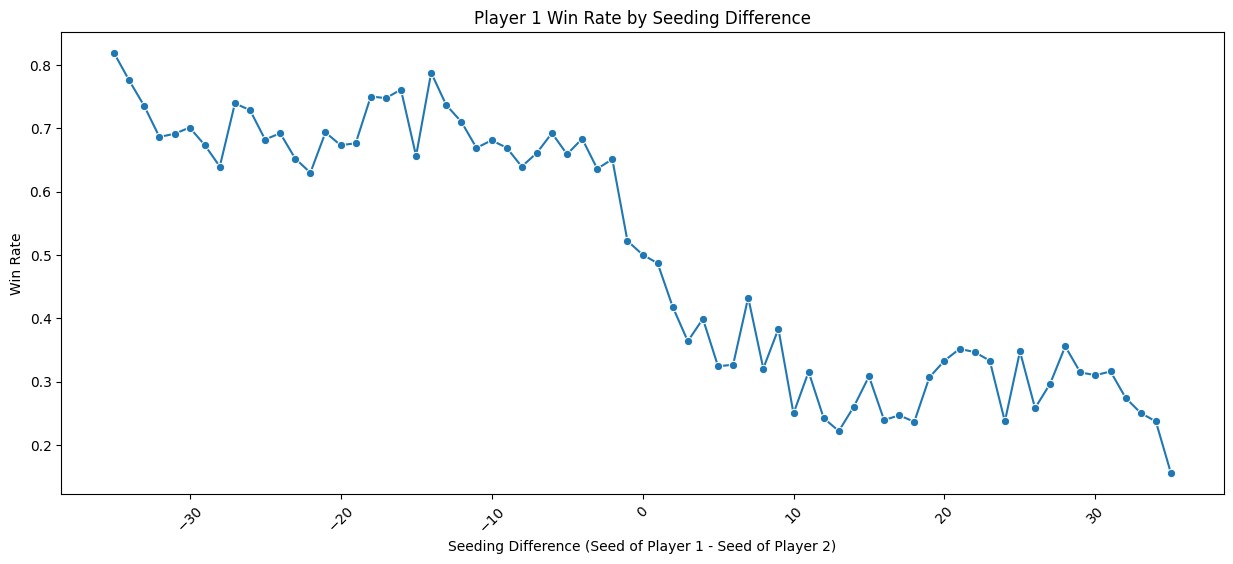

In [ ]:
# Calculate win rate by seeding difference
seed_diff_winrate = games.groupby('seeding_difference')['target'].mean().reset_index()

# Plot
plt.figure(figsize = (15, 6))
sns.lineplot(data = seed_diff_winrate, x='seeding_difference', y='target', marker="o")
plt.xticks(rotation=45)
plt.ylabel("Win Rate")
plt.xlabel("Seeding Difference (Seed of Player 1 - Seed of Player 2)")
plt.title("Player 1 Win Rate by Seeding Difference")

### Rank(1): Does the number of ranking points a player has impact their ability to win?

Text(0.5, 1.0, 'Player 1 Win Rate by Ranking Points')

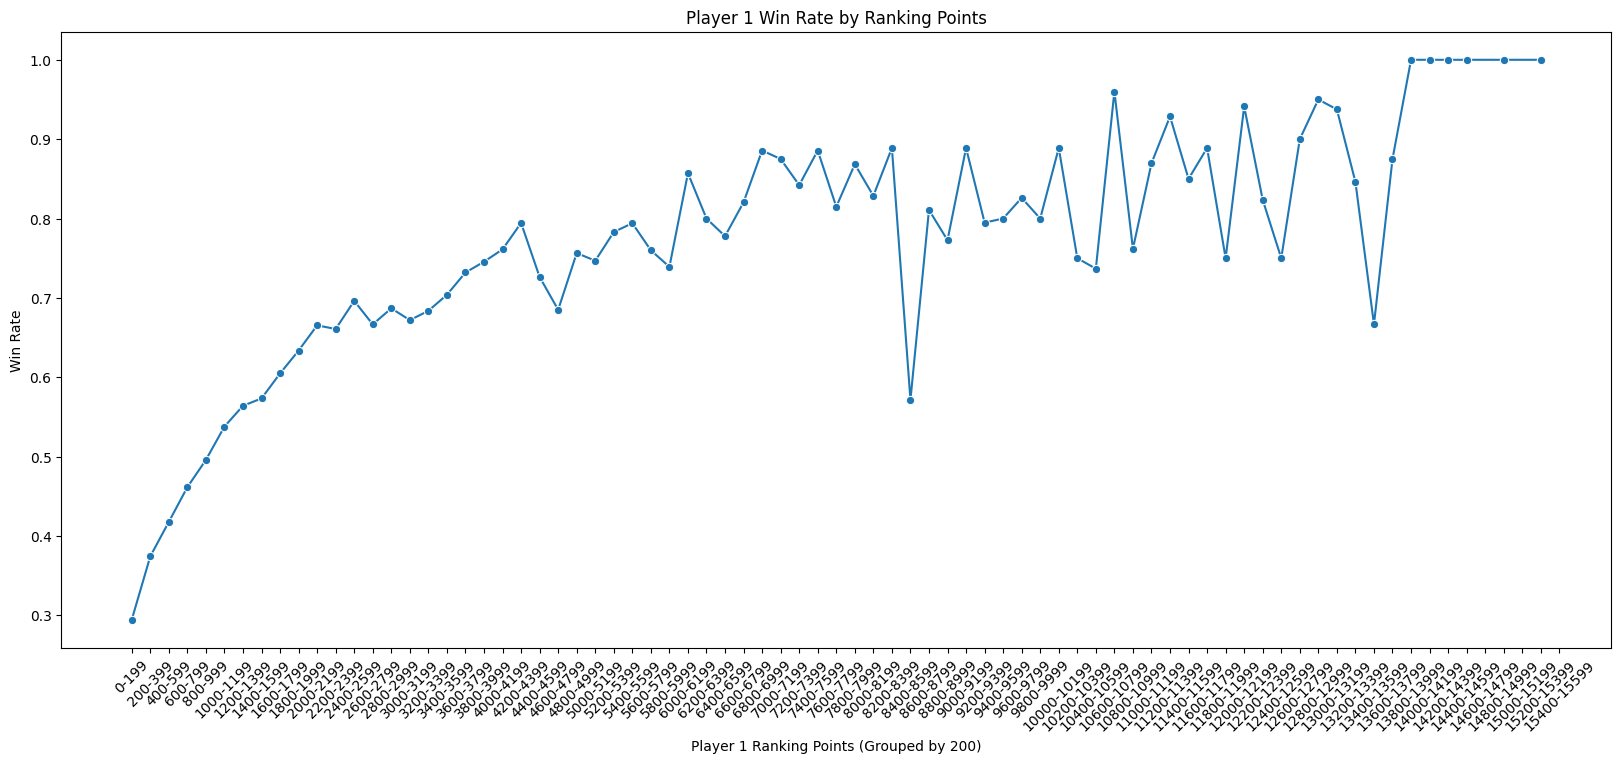

In [ ]:
games['player_1_rank_points'] = games['player_1_rank_points'].astype(int)

# Determine the bin edges dynamically based on points range
max_points = games['player_1_rank_points'].max()

bin_edges = list(range(0, max_points + 1, 200))

# Generate bin labels: one fewer label than bin edges
bin_labels = [f"{i}-{i+199}" for i in range(0, max_points + 1, 200)]

# Ensure the number of labels is one less than the number of bin edges
bin_labels = bin_labels[:len(bin_edges) - 1]

# Create bins based on these edges
games['points_bin'] = pd.cut(games['player_1_rank_points'], bins=bin_edges, labels=bin_labels)

# Calculate win rate per points group
points_bin_winrate = games.groupby('points_bin', observed=False)['target'].mean().reset_index()

# Plot
plt.figure(figsize = (20, 8))
sns.lineplot(data=points_bin_winrate, x='points_bin', y='target', marker="o")
plt.xticks(rotation=45)
plt.ylabel("Win Rate")
plt.xlabel("Player 1 Ranking Points (Grouped by 200)")
plt.title("Player 1 Win Rate by Ranking Points")

### Rank(2): Does the tournament(Grand Slam/Masters/Location) affect how important the rank is?

<ipython-input-600-180a472c9d6a>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tourney_rank_winrate = games.groupby(['tourney_level', 'points_bin'])['target'].mean().reset_index()


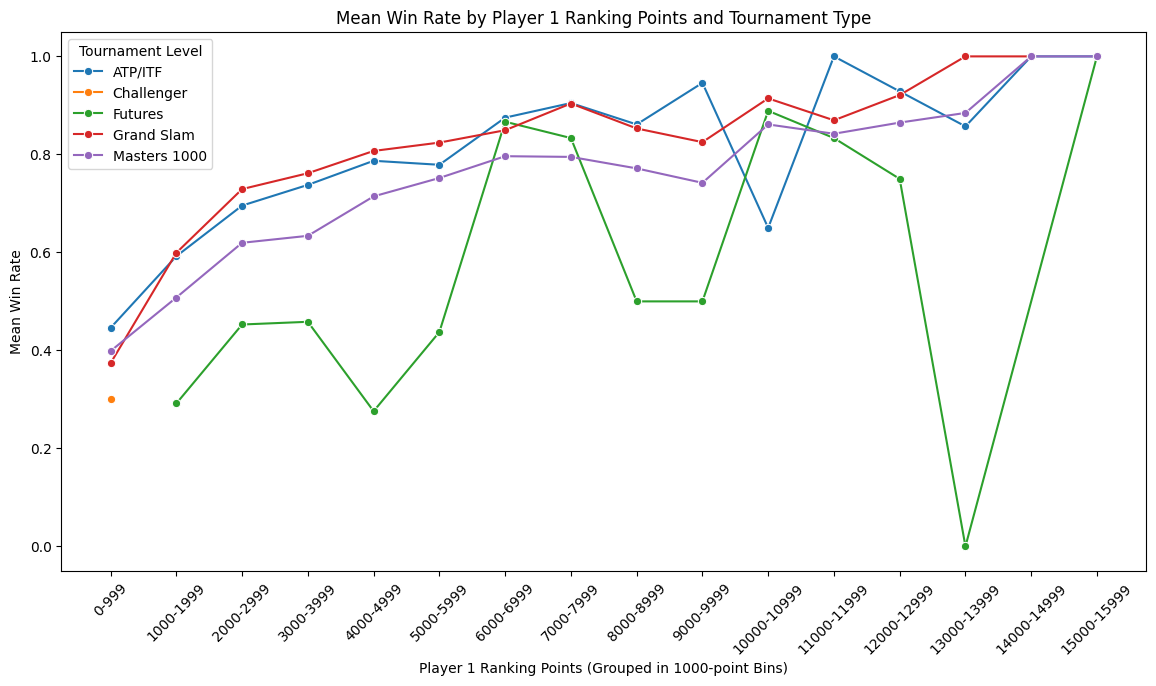

In [ ]:
# Group rank points into larger bins, by 1000 points intervals
bin_edges = list(range(0, max(games['player_1_rank_points']) + 1000, 1000))
bin_labels = [f"{i}-{i+999}" for i in range(0, max(games['player_1_rank_points']), 1000)]

# Create bins based on these edges
games['points_bin'] = pd.cut(games['player_1_rank_points'], bins=bin_edges, labels=bin_labels)

# Group by tourney_level and points_bin, calculate mean win rate
tourney_rank_winrate = games.groupby(['tourney_level', 'points_bin'])['target'].mean().reset_index()

# Plot a scatterplot with difference colored lines
plt.figure(figsize=(14, 7))
sns.lineplot(data=tourney_rank_winrate, x='points_bin', y='target', hue='tourney_level', marker="o")
plt.xticks(rotation=45)
plt.ylabel("Mean Win Rate")
plt.xlabel("Player 1 Ranking Points (Grouped in 1000-point Bins)")
plt.title("Mean Win Rate by Player 1 Ranking Points and Tournament Type")
plt.legend(title='Tournament Level', loc='upper left');

### Rank(3): Does having more ranking points improve one’s chances as time goes on (with longer games)?

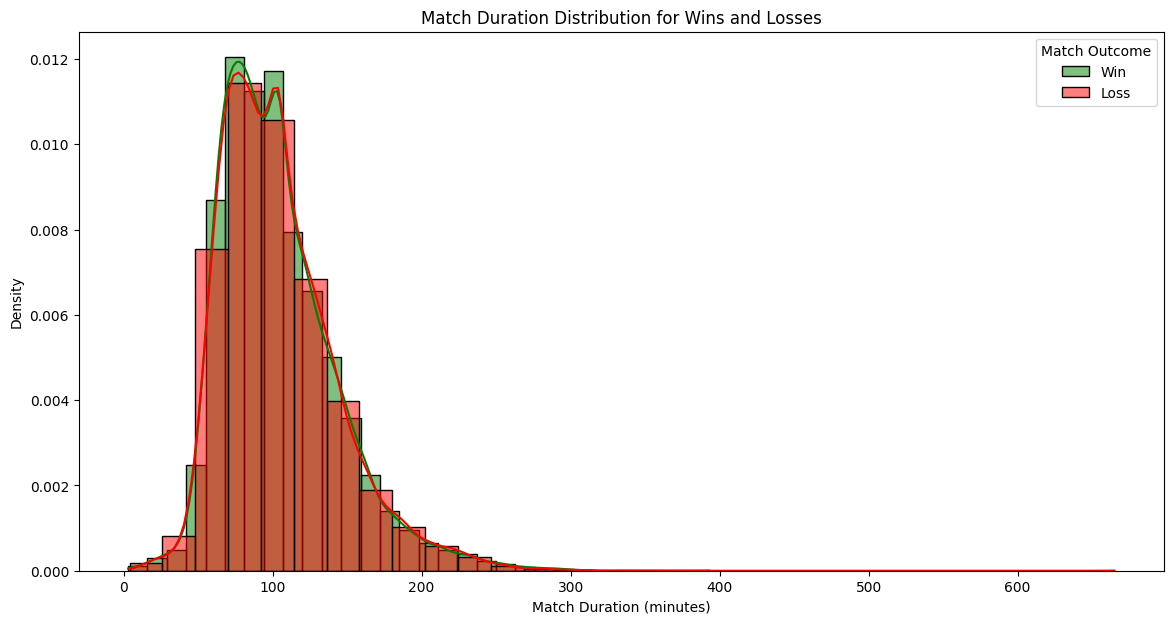

In [ ]:
max_points = games['player_1_rank_points'].max()
# 200 points intervals
bins = list(range(0, max_points + 200, 200))

# Adding a label for each of the bins
labels = [f'{i}-{i+199}' for i in range(0, max_points, 200)]

# Create a new column 'rank_group' for the ranking bins
games['rank_group'] = pd.cut(games['player_1_rank_points'], bins=bins, labels=labels, right=False)

# Split the data into wins (target == 1) and losses (target == 0)
win_data = games[games['target'] == 1]
loss_data = games[games['target'] == 0]

# Create histograms for match duration distribution for win and loss categories
plt.figure(figsize=(14, 7))

# Plot histogram for wins
sns.histplot(win_data['minutes'], kde=True, color='green', label='Win', bins=30, stat='density')

# Plot histogram for losses
sns.histplot(loss_data['minutes'], kde=True, color='red', label='Loss', bins=30, stat='density')

# Title and labels
plt.title('Match Duration Distribution for Wins and Losses')
plt.xlabel('Match Duration (minutes)')
plt.ylabel('Density')
plt.legend(title='Match Outcome')

(0.0, 1.0)

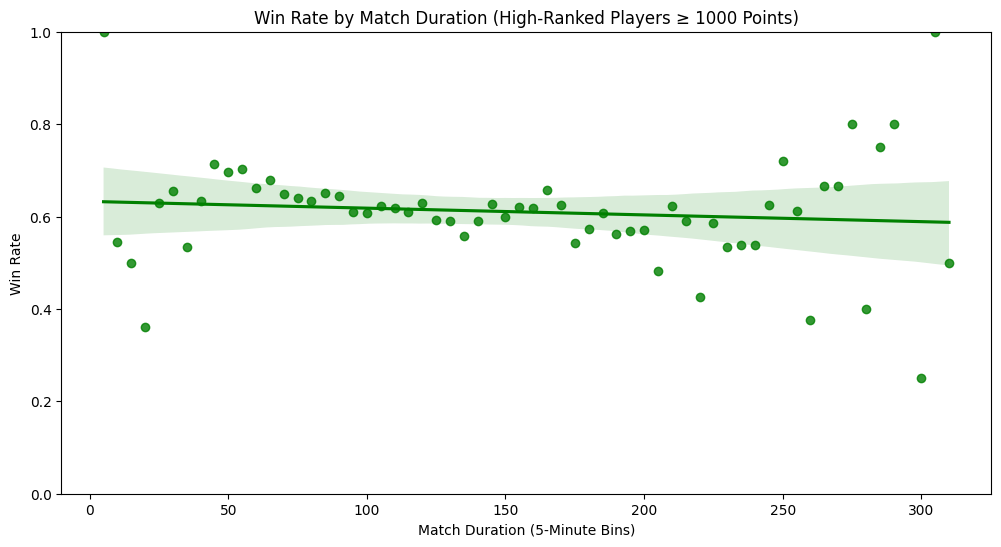

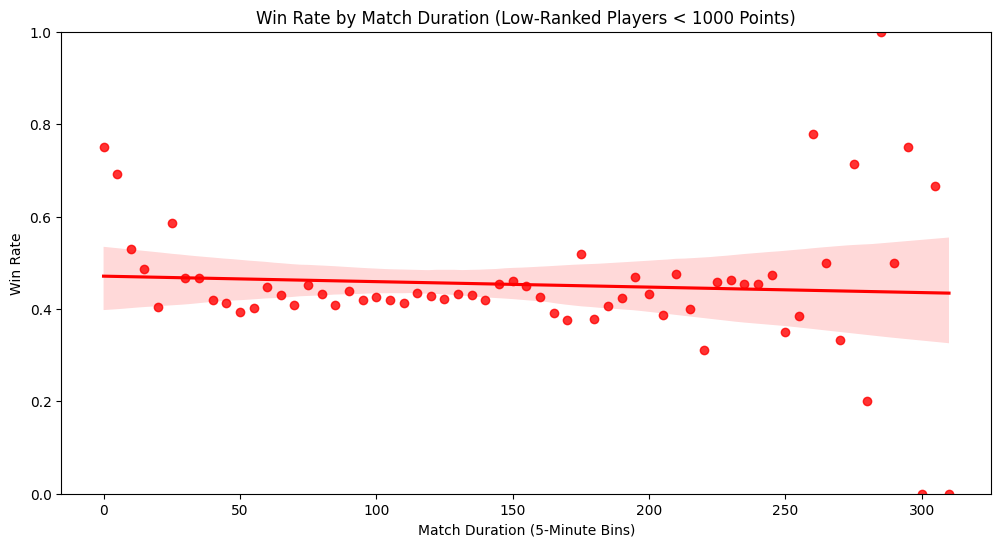

In [ ]:
normal_games = games[games['minutes'] <= 330]

# Define rank groups
high_ranked = normal_games[normal_games['player_1_rank_points'] >= 1000].copy()
low_ranked = normal_games[normal_games['player_1_rank_points'] < 1000].copy()

# Create 5-minute bins
high_ranked['minute_bin'] = (high_ranked['minutes'] // 5) * 5
low_ranked['minute_bin'] = (low_ranked['minutes'] // 5) * 5

# Group and calculate win rate
high_winrate = high_ranked.groupby('minute_bin')['target'].mean().reset_index()
low_winrate = low_ranked.groupby('minute_bin')['target'].mean().reset_index()

# Plot for high-ranked players
plt.figure(figsize=(12, 6))
sns.regplot(data=high_winrate, x='minute_bin', y='target', marker='o', color='green')
plt.title('Win Rate by Match Duration (High-Ranked Players ≥ 1000 Points)')
plt.xlabel('Match Duration (5-Minute Bins)')
plt.ylabel('Win Rate')
plt.ylim(0, 1)

# Plot for low-ranked players
plt.figure(figsize=(12, 6))
sns.regplot(data=low_winrate, x='minute_bin', y='target', marker='o', color='red')
plt.title('Win Rate by Match Duration (Low-Ranked Players < 1000 Points)')
plt.xlabel('Match Duration (5-Minute Bins)')
plt.ylabel('Win Rate')
plt.ylim(0, 1)


### Height(1): How much does height matter for a player’s chance of winning?

<Axes: xlabel='player_1_ht', ylabel='target'>

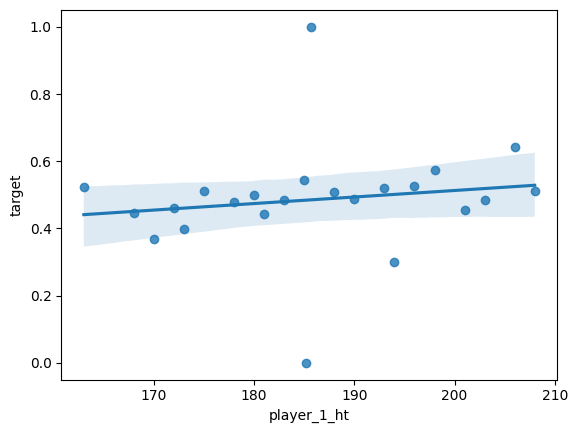

In [ ]:
height_winrate = games.groupby('player_1_ht')['target'].mean().reset_index()
sns.regplot(height_winrate, x = 'player_1_ht', y = 'target')

### Aces(1): How important is getting aces in a game?

<Axes: xlabel='player_1_ace', ylabel='target'>

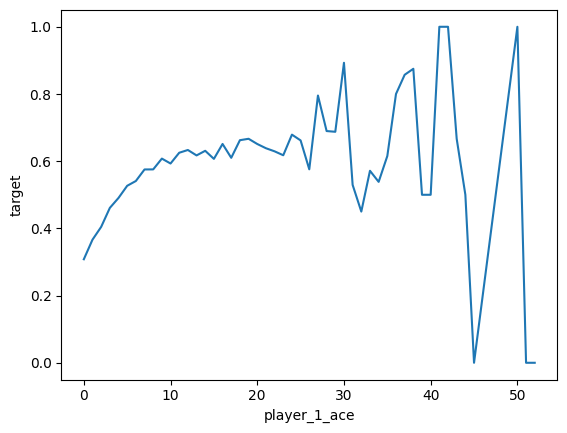

In [ ]:
normal_games = games[games['player_1_ace'] < 100]
aces_winrate = normal_games.groupby('player_1_ace')['target'].mean().reset_index()
sns.lineplot(aces_winrate, x = 'player_1_ace', y = 'target')

### Aces(2): Does the type of court affect how important aces are to win?

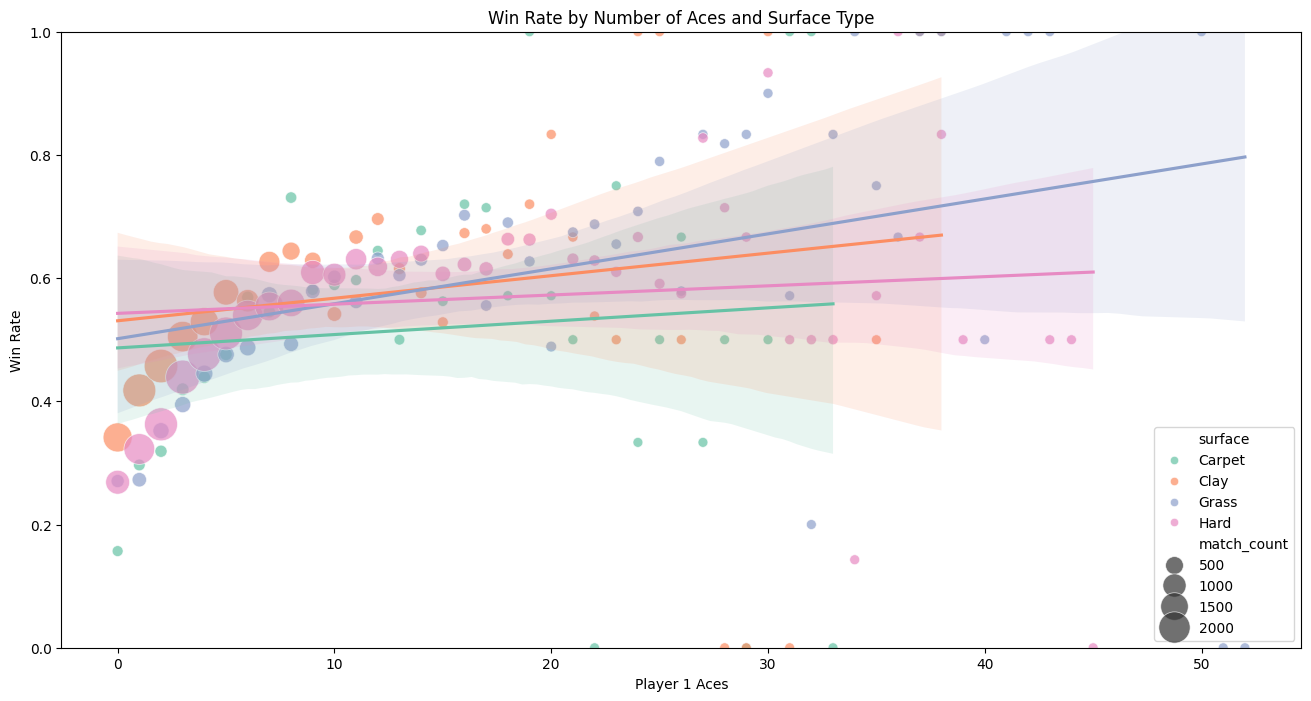

In [ ]:
# Filter out extreme values for aces
normal_games = games[games['player_1_ace'] < 100]

# Aggregate win rate and match count
aces_summary = (normal_games.groupby(['player_1_ace', 'surface']).agg(win_rate=('target', 'mean'), match_count=('target', 'count')).reset_index())

# Plot the bubbles
plt.figure(figsize=(16, 8))

# Scatter plot (bubbles)
scatter = sns.scatterplot(data=aces_summary, x='player_1_ace', y='win_rate', size='match_count', hue='surface', sizes=(50, 600), alpha=0.7, palette='Set2')

# Adding regression lines for each surface
surfaces = aces_summary['surface'].unique()
for i, surface in enumerate(surfaces):
  surface_data = aces_summary[aces_summary['surface'] == surface]
  sns.regplot(data = surface_data, x = 'player_1_ace',y = 'win_rate',scatter=False,color=sns.color_palette('Set2')[i])

plt.title('Win Rate by Number of Aces and Surface Type')
plt.xlabel('Player 1 Aces')
plt.ylabel('Win Rate')
plt.ylim(0, 1);

### Serve(1): Does having a high first serve in number correspond to a higher percent win?


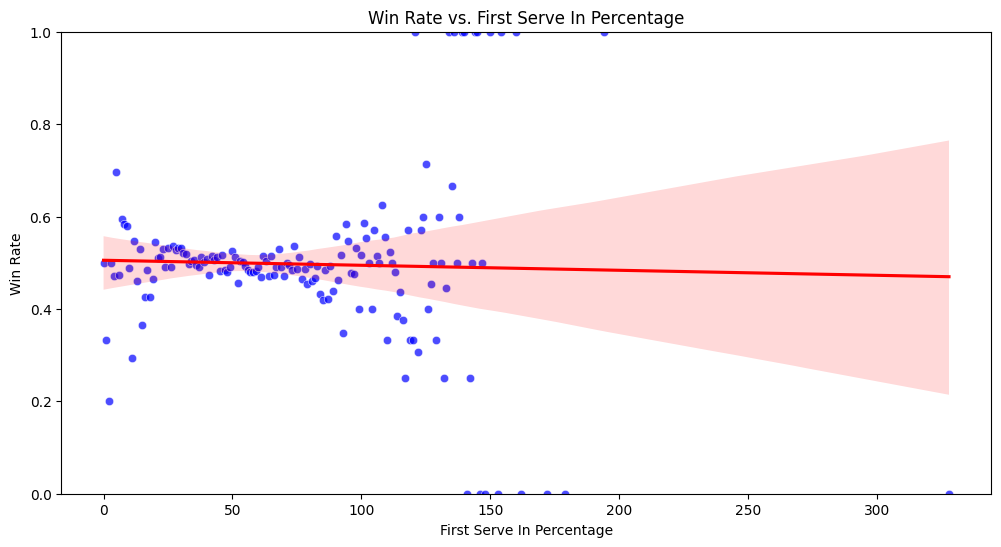

In [ ]:
# Group by first serve in percentage and calculate the mean win rate
first_serve_in_winrate = games.groupby('player_1_1stIn')['target'].mean().reset_index()

# Plot the relationship between first serve in percentage and win rate
plt.figure(figsize=(12, 6))
sns.scatterplot(data=first_serve_in_winrate, x='player_1_1stIn', y='target', color='blue', alpha=0.7)

# Fit a regression line to show the trend
sns.regplot(data=first_serve_in_winrate, x='player_1_1stIn', y='target', scatter=False, color='red')

# Add titles and labels
plt.title('Win Rate vs. First Serve In Percentage')
plt.xlabel('First Serve In Percentage')
plt.ylabel('Win Rate')

# Win rate is between 0 and 1, want to show the entirety
plt.ylim(0, 1)


### Serve(2): What about the comparison between 1st serve points won and 2nd serve points won?

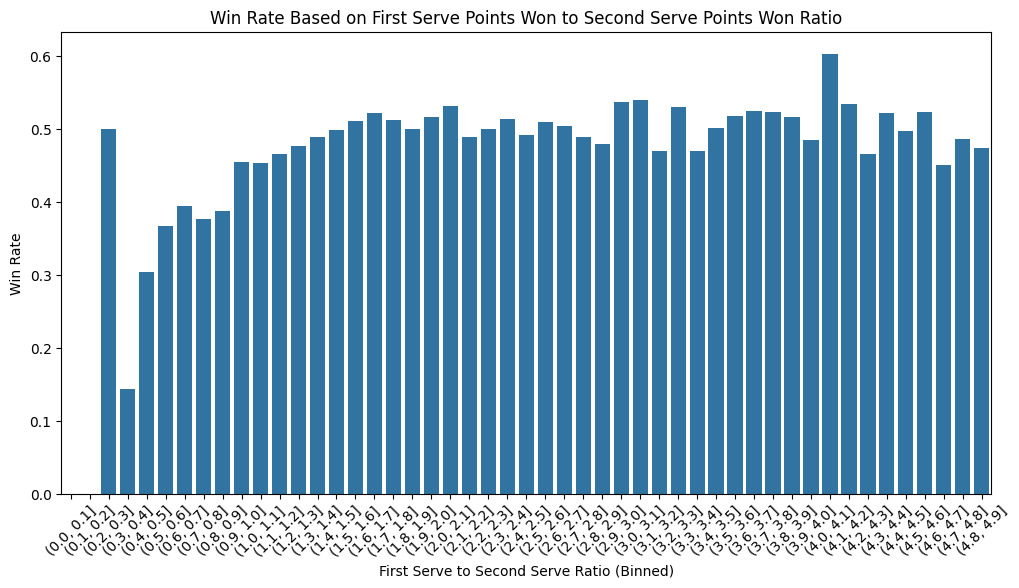

In [ ]:
# Create a new column for the ratio of 1st serve points won to 2nd serve points won
games['1st_vs_2nd_serve_ratio'] = games['player_1_1stWon'] / games['player_1_2ndWon']

# Subset for normal games where the ratio is less than 5
normal_games = games[games['1st_vs_2nd_serve_ratio'] < 5].copy()

# Bin the 1st vs 2nd serve ratio into intervals of 0.1
bin_edges = [x * 0.1 for x in range(int(normal_games['1st_vs_2nd_serve_ratio'].min() * 10), int(normal_games['1st_vs_2nd_serve_ratio'].max() * 10) + 1)]
normal_games['serve_ratio_bin'] = pd.cut(normal_games['1st_vs_2nd_serve_ratio'], bins=bin_edges)

# Calculate win rate for each bin
winrate_by_serve_ratio_bin = normal_games.groupby('serve_ratio_bin', observed=False)['target'].mean().reset_index()

# Plot the win rate based on the binned ratio using a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=winrate_by_serve_ratio_bin, x='serve_ratio_bin', y='target')

# Title and labels
plt.title('Win Rate Based on First Serve Points Won to Second Serve Points Won Ratio')
plt.xlabel('First Serve to Second Serve Ratio (Binned)')
plt.ylabel('Win Rate')
plt.xticks(rotation=45);

In [ ]:
# Drop the column given that it doesn't seem to be in any way useful
games = games.drop('1st_vs_2nd_serve_ratio', axis = 1)

### Break Points(1): Does the number of breakpoints faced correspond to chance of winning?

Text(0, 0.5, 'Win Rate')

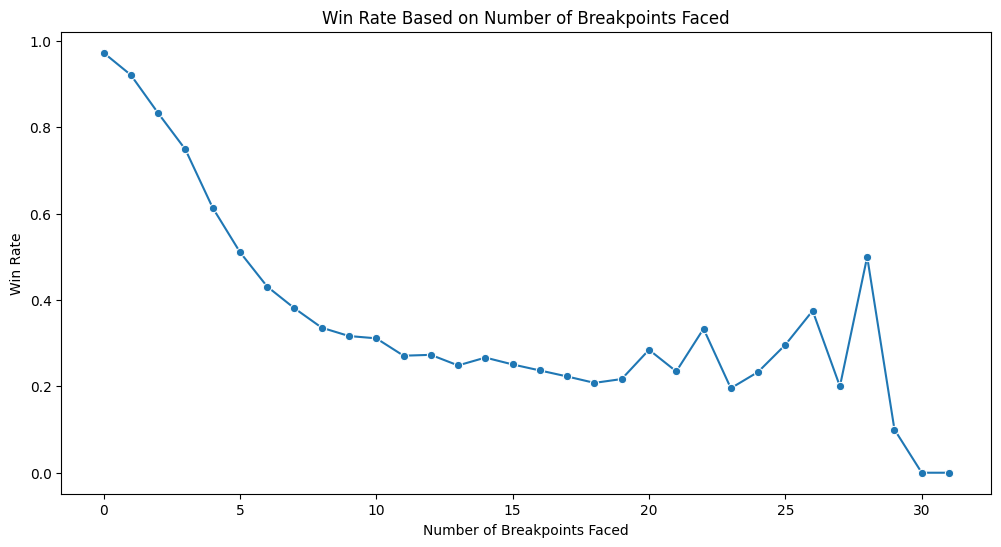

In [ ]:
# Group the data by the number of breakpoints faced and calculate the mean win rate ('target')
breakpoints_winrate = games.groupby('player_1_bpFaced')['target'].mean().reset_index()

# Plot the win rate based on the number of breakpoints faced
plt.figure(figsize=(12, 6))
sns.lineplot(data=breakpoints_winrate, x='player_1_bpFaced', y='target', marker="o")

# Title and labels
plt.title('Win Rate Based on Number of Breakpoints Faced')
plt.xlabel('Number of Breakpoints Faced')
plt.ylabel('Win Rate')

### Break Points(2): Does the round in a tournament matter for how important breakpoints are?

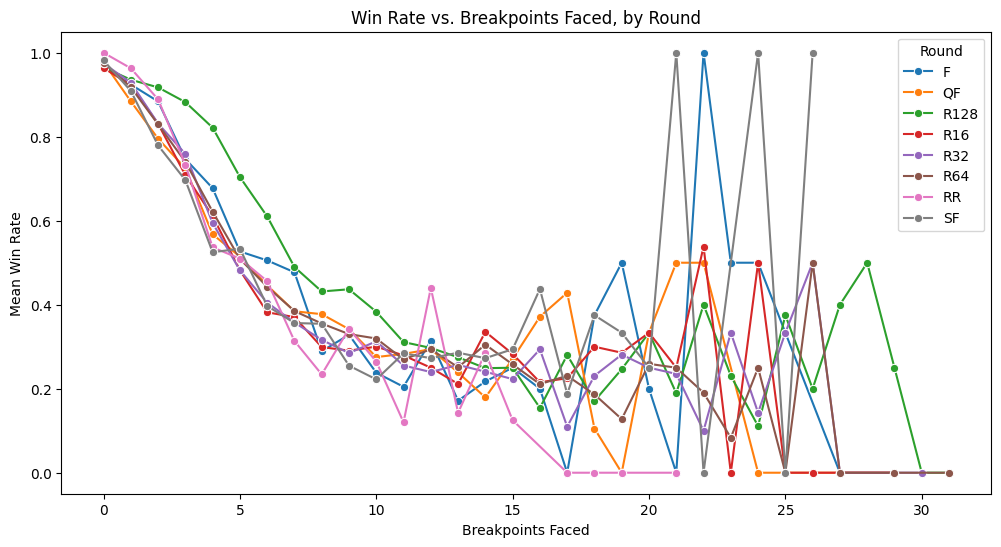

In [ ]:
bp_winrate_by_round = games.groupby(['player_1_bpFaced', 'round'], observed=False)['target'].mean().reset_index()

# Plot: Win rate vs. breakpoints faced, separated by round
plt.figure(figsize=(12, 6))
sns.lineplot(data=bp_winrate_by_round, x='player_1_bpFaced', y='target', hue='round', marker='o')

# Add titles and labels
plt.title('Win Rate vs. Breakpoints Faced, by Round')
plt.xlabel('Breakpoints Faced')
plt.ylabel('Mean Win Rate')
plt.legend(title='Round')


### Player(1): Does how many games in a row a player has won contribute to their ability to win the next game?

Text(0, 0.5, 'Win Rate in Current Match')

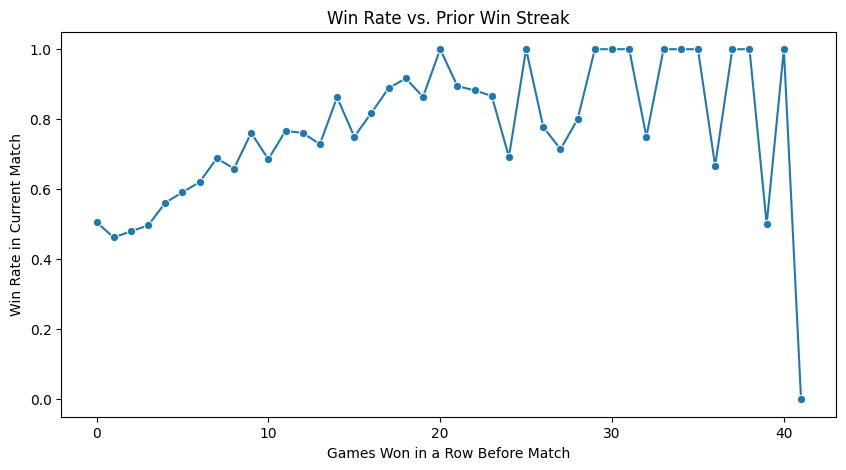

In [ ]:
# Separate out the two players and rename the columns
p1 = games[['tourney_date', 'player_1_name', 'target']].rename(columns={'player_1_name': 'player','target': 'won'})
p2 = games[['tourney_date', 'player_2_name', 'target']].rename(columns={'player_2_name': 'player','target': 'won'})

# player_2 wins if target == 0
p2['won'] = 1 - p2['won']

# Combine and sort by the tournament date, essentially in chronological order
combined = pd.concat([p1, p2], ignore_index=True)
combined = combined.sort_values(['player', 'tourney_date']).reset_index(drop=True)

# Figure out the win streak at each point in time
combined['prev_win'] = combined.groupby('player')['won'].shift(1).fillna(0)
combined['streak_id'] = (combined['prev_win'] != 1).groupby(combined['player']).cumsum()
combined['win_streak'] = combined.groupby(['player', 'streak_id']).cumcount()

# Group by win streak and calculate win rate
streak_winrate = combined.groupby('win_streak')['won'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=streak_winrate, x='win_streak', y='won', marker='o')
plt.title('Win Rate vs. Prior Win Streak')
plt.xlabel('Games Won in a Row Before Match')
plt.ylabel('Win Rate in Current Match')


In [ ]:
games.shape

(44451, 53)

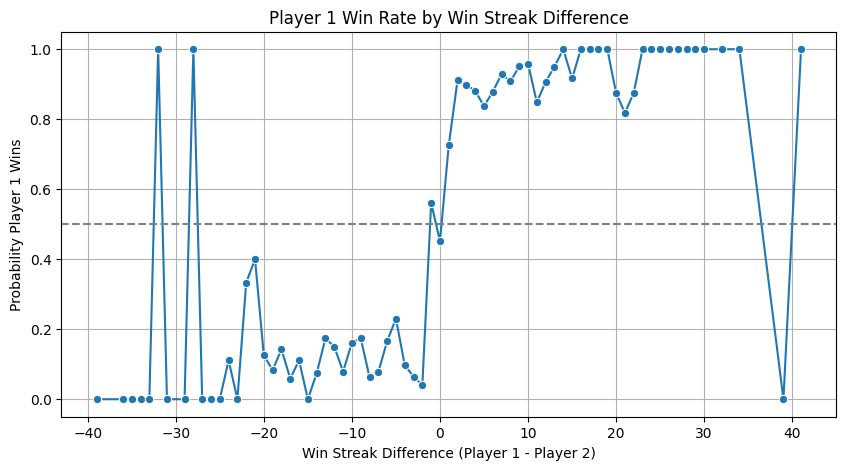

In [ ]:
# Combine both player dataframes into one combined data frame
combined = pd.concat([p1, p2], ignore_index=True)
combined = combined.sort_values(['player', 'tourney_date']).reset_index(drop=True)

# Group based on player the tournament date, essentially the tracker of each tournament
combined['tourney_id'] = combined.groupby('player')['tourney_date'].transform('first')

# Create a streak id that will reset for each player at the start of every new tournament, based on the separate tournament
combined['streak_reset'] = (combined['tourney_id'] != combined['tourney_id'].shift(1)).astype(int)

# Initialize the streak counter and count the number of wins during each tournament
combined['win_streak'] = 0
combined['win_streak'] = combined.groupby(['player', 'streak_reset']).cumcount()

# Sort combined by player and date, maintaining chronological sequence
combined = combined.sort_values(['player', 'tourney_date']).reset_index(drop=True)

# Compute win streaks
def compute_streak(won_series):
  return won_series.groupby((won_series != 1).cumsum()).cumcount() + 1

combined['win_streak'] = combined['won']
combined['win_streak'] = combined.groupby('player')['win_streak'].transform(compute_streak)

# Reset the win streak whenever the won flag is 0, essentially did not win at that tournament
combined.loc[combined['won'] != 1, 'win_streak'] = 0

# Ensure unique pairs for merge
player_streaks = (combined[['player', 'tourney_date', 'win_streak']].drop_duplicates(subset=['player', 'tourney_date'], keep='first'))

# Merge onto games
games = games.merge(player_streaks.rename(columns={'player': 'player_1_name', 'win_streak': 'player_1_win_streak'}), on=['player_1_name', 'tourney_date'],how='left')
games = games.merge(player_streaks.rename(columns={'player': 'player_2_name', 'win_streak': 'player_2_win_streak'}), on=['player_2_name', 'tourney_date'], how='left')

# Compute Difference
games['streak_diff'] = games['player_1_win_streak'] - games['player_2_win_streak']

# Plot winrate by streak difference
streak_winrate = games.groupby('streak_diff')['target'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=streak_winrate, x='streak_diff', y='target', marker='o')
plt.title("Player 1 Win Rate by Win Streak Difference")
plt.xlabel("Win Streak Difference (Player 1 - Player 2)")
plt.ylabel("Probability Player 1 Wins")

### Player(2): Do certain Players play better on certain surfaces?

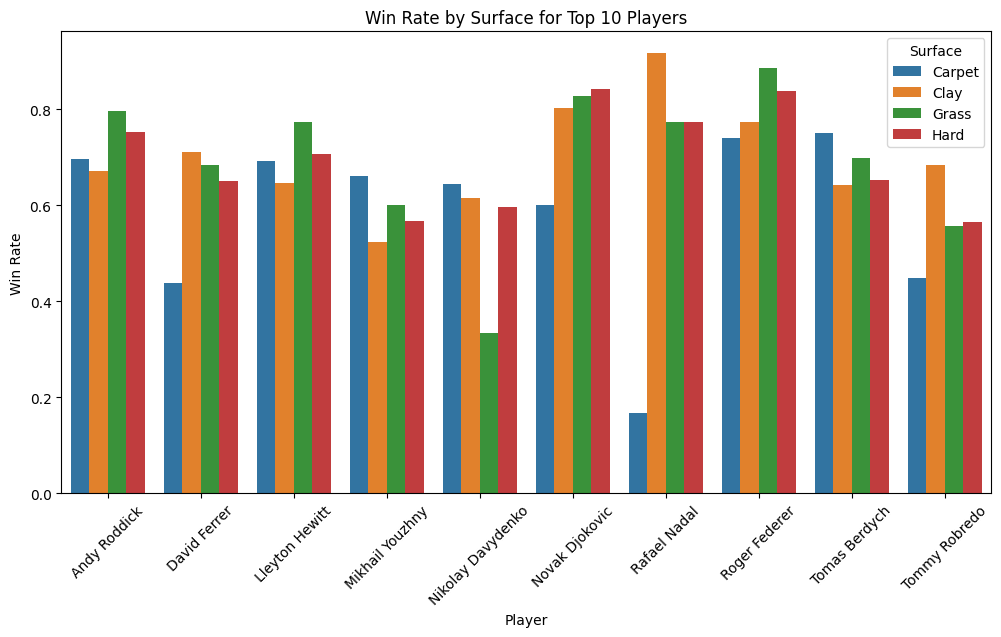

In [ ]:
# Combine both players with match surface and outcome
p1 = games[['surface', 'player_1_name', 'target']].rename(columns={'player_1_name': 'player','target': 'won'})
p2 = games[['surface', 'player_2_name', 'target']].rename(columns={'player_2_name': 'player','target': 'won'})

# player_2 wins if target == 0
p2['won'] = 1 - p2['won']

combined_surface = pd.concat([p1, p2], ignore_index=True)

# Limit to top N most active players for readbility in the graph
top_players = combined_surface['player'].value_counts().head(10).index
filtered = combined_surface[combined_surface['player'].isin(top_players)]

# Group and plot
surface_winrate = filtered.groupby(['player', 'surface'])['won'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=surface_winrate, x='player', y='won', hue='surface')
plt.title('Win Rate by Surface for Top 10 Players')
plt.ylabel('Win Rate')
plt.xlabel('Player')
plt.xticks(rotation=45)
plt.legend(title='Surface')
